<h1> [Análisis de Fourier]

(https://es.wikipedia.org/wiki/Transformada_de_Fourier_discreta) aplicado a soluciones del problema de Sitnikov romboidal <h1>

<h2> Requisitos (INICIO) <h2>



Cargamos el módulo de ecuaciones diferenciales, interpolaciones , pyplot, etc La funcoón que me resuuelve el problema de los dos cuerpos y un filtro de baja frecuencia

In [3]:
using DifferentialEquations, JLD, Interpolations, PyPlot, QuadGK



<h4> Solve2body (Func_r) <h4>

In [2]:
# Solve kepler equation  E=M-e*sen(E) by fixed point iteration
# solkepler(M::Array{Float64},e::Float64,tol::Float64)
# M: mean anomaly Array{Float64}
# e: excentricity Float64
# tol: tolerance, a difference less that tol finished iteration


#include("SolKepler.jl")
#using Interpolations

function Func_r(e::Float64)
	@assert((0<=e && e<1),"Range excentricity is [0,1)")
	dist_peri=1;
	a=dist_peri/(1-e);
	n=a^(-1.5);
	T=2*pi/n;
	t=Array(0:.01:T);
	M=n*t
	E=solkepler(M,e,.0001);
	x=a*(cos.(E)-e);
	y=a*sqrt(1-e^2)*sin.(E);
	t=0:.01:T;
	sol_x_a = interpolate(x, BSpline(Cubic(Line())), OnGrid())
	sol_x=scale(sol_x_a,t)
	sol_y_a = interpolate(y, BSpline(Cubic(Line())), OnGrid())
	sol_y=scale(sol_y_a,t)
	r(t)=sqrt(sol_x[t-floor(t/T)*T]^2+sol_y[t-floor(t/T)*T]^2)
	return r,T,sol_x,sol_y
end

function solkepler(M::Array{Float64},e::Float64,tol::Float64)

"""
Solve kepler equation  E=M-e*sen(E) by fixed point iteration
solkepler(M::Array{Float64},e::Float64,tol::Float64)
M: mean anomaly Array{Float64}
e: excentricity Float64
tol: tolerance, a difference less that tol finished iteration
"""

@assert((0<=e && e<1),"Range excentricity is [0,1)")
filtro=1:length(M);
delta=tol+1
E=deepcopy(M);

while delta>tol 
    E1=M[filtro]+e.*sin.(E[filtro]);
    Error=abs.(E[filtro]-E1);
    delta=maximum(Error);
    E[filtro]=E1;
    filtro=filtro[Error.>tol];
end
return E



end

solkepler (generic function with 1 method)

<h4> smooth.jl <h4>

In [3]:
using DSP
function smooth(y, win_len=11, win_method=2)
# This function requires the DSP package to be installed
# 1: flat
# 2: hanning
# 3: hamming ...
if win_len%2==0
  win_len+=1 # only use odd numbers
end
if win_method == 1
  w=ones(win_len)
elseif win_method==2
  w=DSP.hanning(win_len)
elseif win_method==3
  w=DSP.hamming(win_len)
end

if win_len<3
  return y
elseif length(y)<win_len
  return y
else
        y_new = [2*y[1]-flipdim(y[1:win_len],1); y[:]; 2*y[end]-flipdim(y[end-win_len:end],1)]
  y_smooth = conv(y_new, w/sum(w))
  ind = floor(Int, 1.5*win_len)
  return y_smooth[1+ind:end-ind-1]
end

end

smooth (generic function with 3 methods)

<h4> HallaMasas <h4>

In [4]:
function ColinealInv(x)
  #x vector fila de posiciones
  l=size(x)[2]
  D=ones(l,1)*x
  C=D-D'
  A=((abs.(C)).^(-3)).*C
  for i=1:l
    A[i,i]=0
  end
  return A\(-x')
end

ColinealInv (generic function with 1 method)

<h4> Función resolvente de la EDO <h4>

In [5]:
e=0.1
x₁=0.6
y₁=0.4
m=ColinealInv([-1 -x₁ -x₁*y₁ x₁*y₁ x₁ 1])[4:6]
s=[x₁*y₁ x₁ 1]
#include("Solve2body.jl")
        
r,T=Func_r(e);
        

function Fuerza3c(du,u,p,t)
    m=p[1]
    s=p[2]
    r=p[3]
    R = (r(t)^2*s.^2 +u[1]^2).^(1.5)
    du[1] = u[2]
    du[2] = -2*sum(m./R*u[1])
end

t₀=0.0

alg=Vern9()

function SolveSit(u0,tspan)
    prob_ode_trescuerpos = ODEProblem(Fuerza3c,u0,tspan,[m,s,r]);
    sol = solve(prob_ode_trescuerpos,alg,dt=1e-3,abstol = 1e-12, reltol = 1e-12);
    return sol
end

SolveSit (generic function with 1 method)

In [6]:
tspan=(0.0,10.0)
u0=[2.04,0.0]
soll=SolveSit(u0,tspan)
g(t)=sol(t)[1]

g (generic function with 1 method)

<h2> Requisitos (FINAL) <h2>

<h4> Graficamos el diagrama de fases <h4>

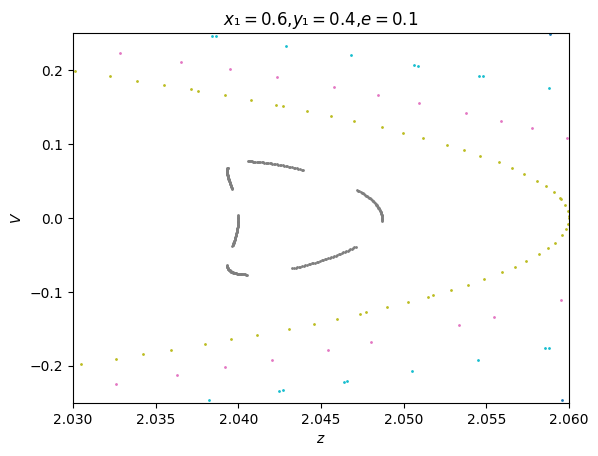

(-0.25, 0.25)

In [7]:
#CARGAMOS EL ARCHIVO QUE QUEREMOS
B=load("DiffEq_Datos_e_0.1algOrdinaryDiffEq.Vern9()pos_ini(0.6, 0.4).jld")


#RECOGEMOS LOS DATOS DEL ARCHIVO

nn=size(B["z"])[1]# Cantidad de fotos sacadas
alturas=size(B["z"])[2] # Cantidad de posiciones iniciales
z=B["z"]
v=B["v"]
e=B["e"] # exentricidad
x₁=B["posini"][1]
y₁=B["posini"][2]
print(size(nn))

#HACEMOS LA GRÁFICA

fig, ax=subplots()
xlabel(L"z")
ylabel(L"V")
title(L"x₁="*string(x₁)*","L"y₁="*string(y₁)*","*L"e="*string(e))
xlim(-6,6)
ylim(-4,4)

for i ∈ range(1,alturas)
    zz=z[:,i]
    vv=v[:,i]
    ax[:scatter](zz,vv,s=1)
end
xlim(2.03,2.06)
ylim(-0.25,0.25)

 FFT análisis en resonancia 1:1, punto 

$u_0=(2.466,0)$
Vamos a calcular la transformada discreta de fourier en el intervalo $[0,400T]$, en genral a veces en otros intervalos. Vamos a generar una muestra de $N=20\times 400+1$ puntos en ese intervalo. Por ende $N$ será el orden de la serie tringonomérica involucrada. Los coeficientes del desarrollo se calcula con la transformada rápida y=fft(z), donde $y[n]=\alpha_{n-1}-\beta_{n-1}i$ y
$$z(t)\sim\frac{1}{N}\left[ \alpha_0+2\sum_{n=1}^{4000}\alpha_{n}\cos\left(\frac{2\pi nt_j}{400T}\right)+\beta_n\sin\left(\frac{2\pi nt_j}{400T}\right)   \right]=
\frac{1}{N}\left[ \alpha_0+2\sum_{n=1}^{4000}\alpha_{n}\cos\left(\frac{2\pi \nu_nt_j}{T}\right)+\beta_n\sin\left(\frac{2\pi \nu_nt_j}{T}\right)   \right],$$
donde $\nu_n=\frac{n}{400}$. Estas frecuencias estan normalizadas para que $\nu=1$ corresponda a periodo $T$. Hemos dividido el espacio de frecuencias en saltos de 1/400=0.0025 y van de 0 a 10. Podemos captar componentes periódicas desde periodos de $400T$ a $T/10$.

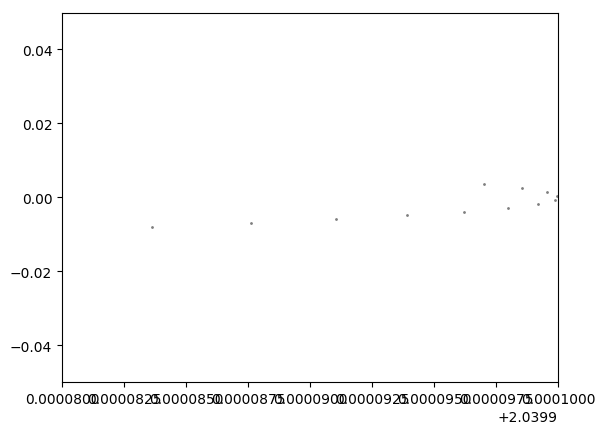

(-0.05, 0.05)

()

In [8]:
fig, ax=subplots()
#pygui(true)
for i ∈ range(1,alturas)
    zz=z[:,i]
    vv=v[:,i]
    ax[:scatter](zz,vv,s=1)
end
xlim(2.03998,2.04)
ylim(-0.05,0.05)

In [9]:
u0=(2.04,0)

(2.04, 0)

In [10]:
CantPer=nn
T_1=CantPer*T
tspan=(0,T_1)
u0=[2.04,0.0]
sol=SolveSit(u0,tspan)
g(t)=sol(t)[1]
nn

1001

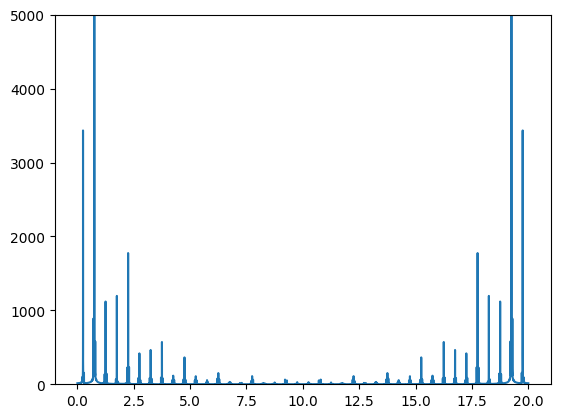

(0, 5000)

In [11]:
t=linspace(0,T_1,20*CantPer+1);
z=g.(t);
y=fft(z)
Y=abs.(y);
j=0:length(Y)-1
#pygui(true)
#pygui(false)
plot(j/CantPer,Y)
#xlim(0,3)
ylim(0,5000)

<h1> Prueba del método "Análisis de frecuencia"  <h1>

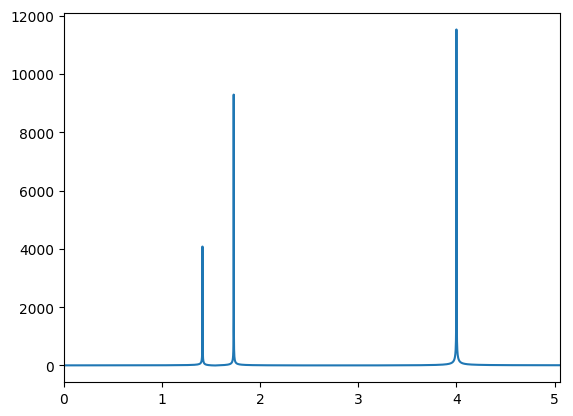

(0, 5.0505)

In [30]:
f1(t)=2*cos(sqrt(3)*t)+3*sin(4*t)+cos(sqrt(2)*t)
g(t)=exp.(im*t)
L=1000
precicion=10101
t=linspace(-π*L,π*L,precicion);
zz=f1.(t)
yy=fft(zz)
YY=abs.(yy);
j=0:length(YY)-1
#pygui(true)
#pygui(false)
plot(j/(L),YY)
xlim(0,precicion/(L)/2)



In [111]:

function prodescalar(t::Float64)
end


10000-element Array{Float64,1}:
 4.589  
 4.589  
 4.58901
 4.58902
 4.58903
 4.58905
 4.58907
 4.58909
 4.58912
 4.58915
 4.58918
 4.58922
 4.58926
 ⋮      
 4.58926
 4.58922
 4.58918
 4.58915
 4.58912
 4.58909
 4.58907
 4.58905
 4.58903
 4.58902
 4.58901
 4.589  